In [2]:
#!pip install scikit-image

In [5]:
#!pip install minisom

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10663 sha256=4aec88cf5b1aab75de4e21b8bedf52da7dc516c1ab52cb7ff0dfc6698a96a9f3
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\61\e8\de\cd2df73e85e467e1cf90ff918c6d6f388eff8e9029dae8bd78
Successfully built minisom


In [12]:
import os
import numpy as np
from skimage import io, transform, color
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder
from minisom import MiniSom
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
# extract features from heatmap images
def extract_features_from_image(image_path):
    img = Image.open(image_path).convert('L')  # сonvert to grayscale
    img_data = np.array(img)  # сonvert to numpy array
    feature = np.mean(img_data)  # уxtract mean intensity as feature (example)
    return feature

In [3]:
image_directory = "диплом/"
image_files = os.listdir(image_directory)
image_paths = [os.path.join(image_directory, img) for img in image_files]

In [4]:
# extract features from each image
features = []
for img_path in image_paths:
    feature = extract_features_from_image(img_path)
    features.append(feature)

In [8]:
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(np.array(features).reshape(-1, 1))

In [9]:
# train SOM
som_grid_rows = 10
som_grid_columns = 10
som = MiniSom(som_grid_rows, som_grid_columns, normalized_features.shape[1], sigma=0.3, learning_rate=0.5)
som.random_weights_init(normalized_features)
som.train_batch(normalized_features, 1000, verbose=True)


 [    0 / 1000 ]   0% - ? it/s
 [    0 / 1000 ]   0% - ? it/s
 [    1 / 1000 ]   0% - 0:00:00 left 
 [    2 / 1000 ]   0% - 0:00:00 left 
 [    3 / 1000 ]   0% - 0:00:00 left 
 [    4 / 1000 ]   0% - 0:00:00 left 
 [    5 / 1000 ]   0% - 0:00:00 left 
 [    6 / 1000 ]   1% - 0:00:00 left 
 [    7 / 1000 ]   1% - 0:00:00 left 
 [    8 / 1000 ]   1% - 0:00:00 left 
 [    9 / 1000 ]   1% - 0:00:00 left 
 [   10 / 1000 ]   1% - 0:00:00 left 
 [   11 / 1000 ]   1% - 0:00:00 left 
 [   12 / 1000 ]   1% - 0:00:00 left 
 [   13 / 1000 ]   1% - 0:00:00 left 
 [   14 / 1000 ]   1% - 0:00:00 left 
 [   15 / 1000 ]   2% - 0:00:00 left 
 [   16 / 1000 ]   2% - 0:00:00 left 
 [   17 / 1000 ]   2% - 0:00:00 left 
 [   18 / 1000 ]   2% - 0:00:00 left 
 [   19 / 1000 ]   2% - 0:00:00 left 
 [   20 / 1000 ]   2% - 0:00:00 left 
 [   21 / 1000 ]   2% - 0:00:00 left 
 [   22 / 1000 ]   2% - 0:00:00 left 
 [   23 / 1000 ]   2% - 0:00:00 left 
 [   24 / 1000 ]   2% - 0:00:00 left 
 [   25 / 1000 ]   2% - 0

In [10]:
# clustering using MiniSom
cluster_labels = np.array([som.winner(f) for f in normalized_features])

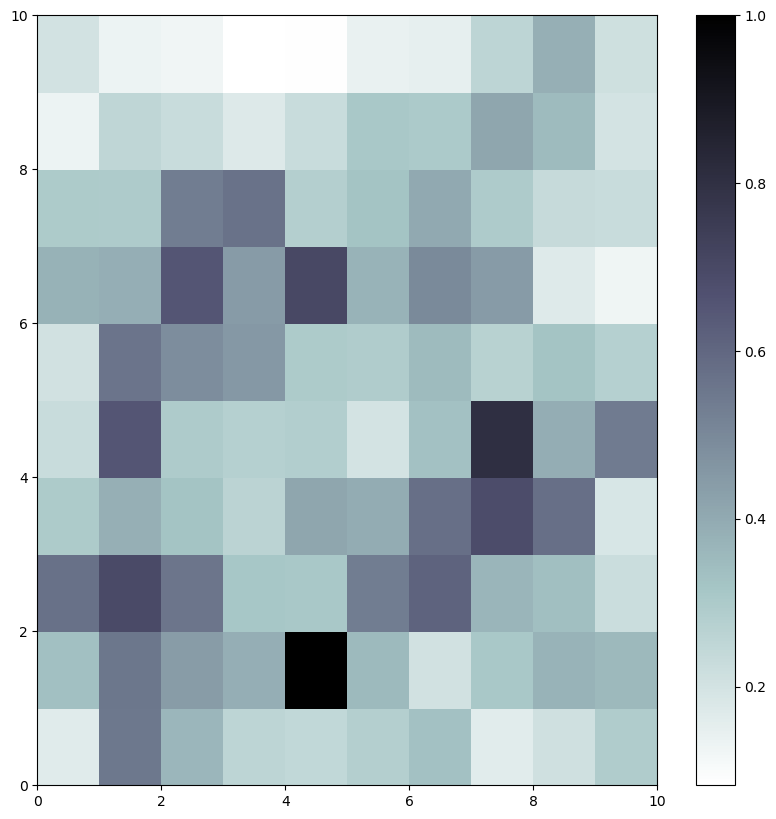

In [13]:
# Distance map
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

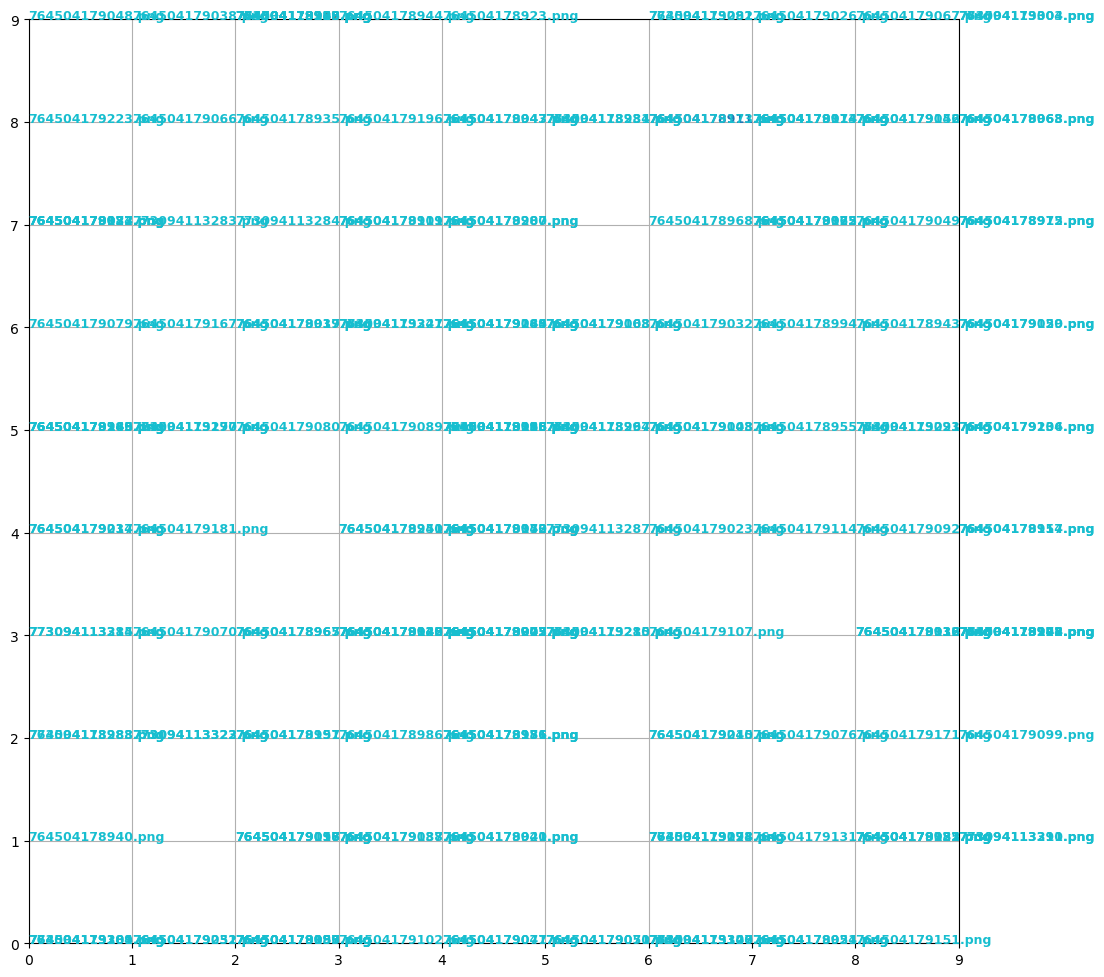

In [21]:
# visualize the clustered heatmap
def visualize_clustered_heatmap(som, cluster_labels, image_files):
    plt.figure(figsize=(12, 12))
    for i, (x, y) in enumerate(cluster_labels):
        plt.text(x, y, image_files[i], color=plt.cm.tab10(i/2.), fontdict={'weight': 'bold', 'size': 9})
    plt.xticks(np.arange(som._weights.shape[0]))
    plt.yticks(np.arange(som._weights.shape[1]))
    plt.grid()

visualize_clustered_heatmap(som, cluster_labels, image_files)
plt.show()

In [ ]:
# This code saves pictures into clusters based on SOM
## Convert cluster_labels to a list of tuples
cluster_labels_list = [tuple(label) for label in cluster_labels]

# Create clusters
clusters = {}
for i, label in enumerate(cluster_labels_list):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(image_files[i])

# Print or use the clusters
for cluster, images in clusters.items():
    print(f'Cluster {cluster}: {images}')

In [ ]:
## We need to somehow visualize the above code

import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10, 10))

for cluster, images in clusters.items():
    for image in images:
        cluster_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))  # Random color for each cluster
        plt.scatter(random.random(), random.random(), color=cluster_color, s=5)  # Use small dots for the images

plt.axis('off')  # Turn off axis for a cleaner plot
plt.title('Cluster Visualization')

plt.show()

In [22]:
# OR assign clusters using K-Means on the SOM grid
som_weights = som.get_weights()
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(som_weights.reshape(-1, normalized_features.shape[1]))

C:\Users\User\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


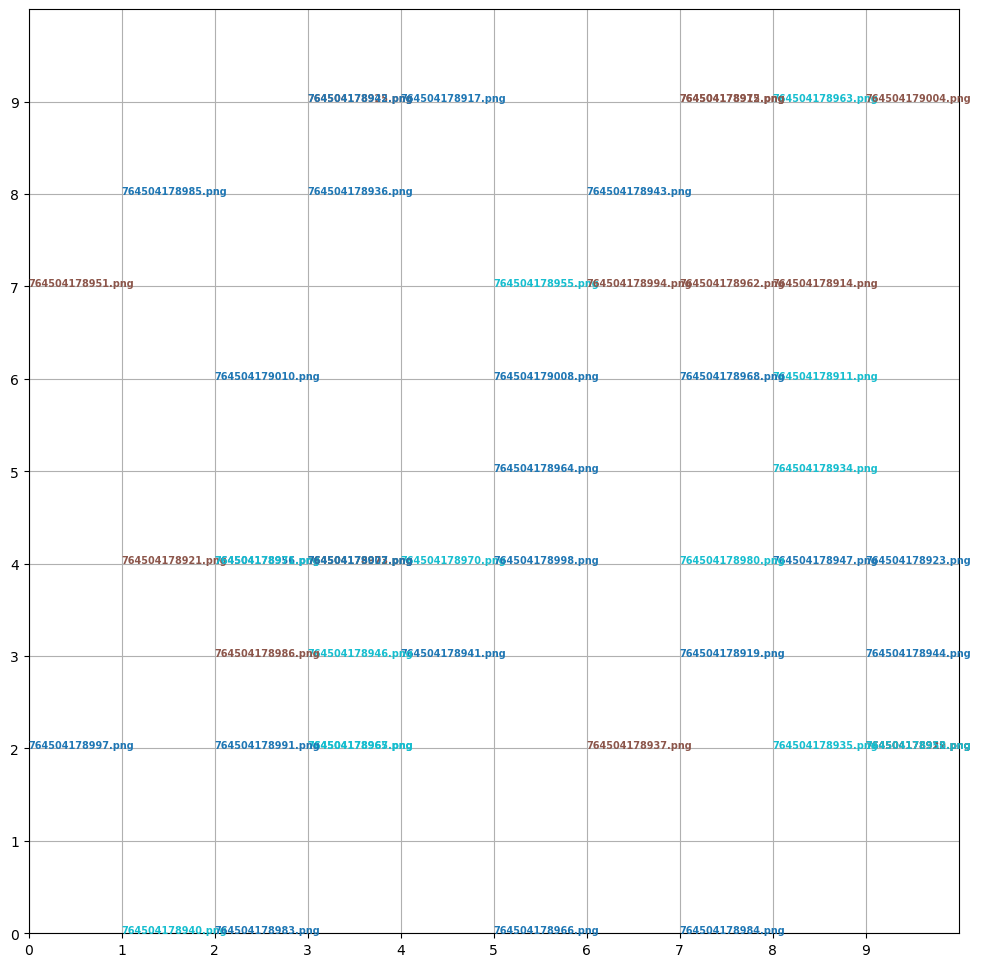

In [24]:
# limited results
def visualize_clustered_heatmap(som, cluster_labels, normalized_features, image_files, max_results=50):
    plt.figure(figsize=(12, 12))
    shown_images = 0
    for i, f in enumerate(normalized_features):
        if shown_images >= max_results:
            break  # Limit the number of displayed images
        winner = som.winner(f)
        plt.text(winner[1], winner[0], image_files[i], color=plt.cm.tab10(cluster_labels[i]/2.), fontdict={'weight': 'bold', 'size': 7})
        shown_images += 1
    plt.xticks(np.arange(som._weights.shape[1]))
    plt.yticks(np.arange(som._weights.shape[0]))
    plt.xlim(0, som._weights.shape[1])
    plt.ylim(0, som._weights.shape[0])
    plt.grid()

# Call the updated visualization function
visualize_clustered_heatmap(som, cluster_labels, normalized_features, image_files, max_results=50)
plt.show()
